# Predicting Credit Card Default Behavior
Authors: Daniel Park | Yiting Sun | Jellia Ma | Han Qin

In [1]:
set.seed(123)
install.packages(c("caret", "dplyr", "ggplot2", "e1071", "caTools", "tidyverse"))
library(caret)
library(dplyr)
library(ggplot2)
library(e1071)
library(caTools)
library(class)
library(tidyverse) 


The downloaded binary packages are in
	/var/folders/0p/zs3c69xd4q7d14yr1s25mxjh0000gn/T//RtmpvK87ka/downloaded_packages


Loading required package: ggplot2

Loading required package: lattice


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ lubridate 1.9.4     ✔ tibble    3.2.1
✔ purrr     1.0.2     ✔ tidyr     1.3.1
✔ readr     2.1.5     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
✖ purrr::lift()   masks caret::lift()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


## I. Summary

In this study, we developed a classification model to predict whether credit card customers will default based on their demographic features, financial behaviors, and payment history. Using the Default of Credit Card Clients Dataset (https://www.kaggle.com/datasets/uciml/default-of-credit-card-clients-dataset/data), we analyzed key factors that contribute to default risk. 

Our goal was to build a predictive model that can assist financial institutions in assessing credit risk more effectively. The k-nearest neighbors (KNN) algorithm was implemented to determine whether a customer will default in the next month. The model was trained on historical data, incorporating variables such as given credit limit, repayment status, history payments amount, and demographic characteristics. We evaluated its performance using confusion matrix. The KNN classification model achieved an accuracy of 79.97%, with high sensitivity (93.77%) but low specificity (31.35%), indicating that while the model effectively identifies non-defaulters, it struggles with correctly predicting actual defaulters.

## II. Introduction

By 2023, approximately 1.25 billion people worldwide have credit cards, which is nearly 16% of the global population (Radage, 2023). People rely on credit cards for everyday purchases, financial flexibility, and managing expenses. As credit card usage continues to grow, so does the risk of default, which is a significant concern for financial institutions. Credit card default occurs when a borrower fails to make their minimum payment obligations over an extended period of time (Streaks, 2024). Understanding the factors that contribute to default can help banks and credit card companies make informed lending decisions and develop better risk assessment models. Therefore, our research question is: 

    Will credit card customers default based on their demographic features, financial behaviours, and payment history?


The dataset used in this study is the Default of Credit Card Clients Dataset from the UCI Machine Learning Repository, which contains 30000 observations and 24 features, including information on credit limit, demographic factors, history of payment, and bill statements of credit card clients in Taiwan from April 2005 to September 2005. The target variable default.payment.next.month indicates whether a customer defaulted (1) or not (0).


| Predictor variable | Description |
|--------------------|-------------|
| `CREDIT_LIMIT` |  Amount of given credit in NT dollars |
| `SEX` | Gender (1=male, 2=female) |
| `EDUCATION` |Measure of education levels (1=graduate school, 2=university, 3=high school, 4=others, 5=unknown, 6=unknown) |
| `MARRIAGE` | Marital status (1=married, 2=single, 3=others) |
| `AGE` | Age in years |
| `PAY_0` | Repayment status in September, 2005 (-1=pay duly, 1=payment delay for one month, 2=payment delay for two months, … 8=payment delay for eight months, 9=payment delay for nine months and above) |
| `PAY_2` | Repayment status in August, 2005 (scale same as above) |
| `PAY_3` | Repayment status in July, 2005 (scale same as above) |
| `PAY_4` | Repayment status in June, 2005 (scale same as above) |
| `PAY_5` | Repayment status in May, 2005 (scale same as above) |
| `PAY_6` | Repayment status in April, 2005 (scale same as above)|
| `AVG_BILL_AMT` |Average amount of bill statement from April to September, 2005 (in NT dollar)|
| `AVG_PAY_AMT`  |Average amount of previous payment from April to September, 2005 (in NT dollar)|

Table 1 - Selected and mutated predictor variables used for analysis

## III. Methods & Results

### Data Preprocessing
- Cleaning & Handling missing values & Feature scaling & Train-test split.
	

In [2]:
### Read Data
df <- read.csv("data/UCI_Credit_Card.csv")
head(df)

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,⋯,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
,<int>,<dbl>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
1,1,20000,2,2,1,24,2,2,-1,-1,⋯,0,0,0,0,689,0,0,0,0,1
2,2,120000,2,2,2,26,-1,2,0,0,⋯,3272,3455,3261,0,1000,1000,1000,0,2000,1
3,3,90000,2,2,2,34,0,0,0,0,⋯,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
4,4,50000,2,2,1,37,0,0,0,0,⋯,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
5,5,50000,1,2,1,57,-1,0,-1,0,⋯,20940,19146,19131,2000,36681,10000,9000,689,679,0
6,6,50000,1,1,2,37,0,0,0,0,⋯,19394,19619,20024,2500,1815,657,1000,1000,800,0


Table 2 - Preview of original data set

In [3]:
# Remove unnecessary columns (e.g., ID)
df <- df %>% select(-ID)

# Split into training (80%) and testing (20%)
split <- sample.split(df$default.payment.next.month, SplitRatio = 0.8)
train_df <- subset(df, split == TRUE)
test_df <- subset(df, split == FALSE)

# Check the dimensions of training data
dim(train_df)

# Check class distribution
table(train_df$default.payment.next.month) / nrow(train_df)

# Summary statistics
summary(train_df)


[1] 24000    24


        0         1 
0.7787917 0.2212083 

   LIMIT_BAL           SEX          EDUCATION        MARRIAGE    
 Min.   : 10000   Min.   :1.000   Min.   :0.000   Min.   :0.000  
 1st Qu.: 50000   1st Qu.:1.000   1st Qu.:1.000   1st Qu.:1.000  
 Median :140000   Median :2.000   Median :2.000   Median :2.000  
 Mean   :168505   Mean   :1.603   Mean   :1.856   Mean   :1.547  
 3rd Qu.:240000   3rd Qu.:2.000   3rd Qu.:2.000   3rd Qu.:2.000  
 Max.   :800000   Max.   :2.000   Max.   :6.000   Max.   :3.000  
      AGE            PAY_0              PAY_2             PAY_3        
 Min.   :21.00   Min.   :-2.00000   Min.   :-2.0000   Min.   :-2.0000  
 1st Qu.:28.00   1st Qu.:-1.00000   1st Qu.:-1.0000   1st Qu.:-1.0000  
 Median :34.00   Median : 0.00000   Median : 0.0000   Median : 0.0000  
 Mean   :35.54   Mean   :-0.01708   Mean   :-0.1327   Mean   :-0.1656  
 3rd Qu.:41.00   3rd Qu.: 0.00000   3rd Qu.: 0.0000   3rd Qu.: 0.0000  
 Max.   :79.00   Max.   : 8.00000   Max.   : 8.0000   Max.   : 8.0000  
     PAY_4             PAY_5      

In [4]:
# Check for missing values
sum(is.na(train_df))

[1] 0

In [5]:
# Instead of using each day's amount we compute the average of BILL_AMT and PAY_AMT columns to make it more organized
train_df$AVG_BILL_AMT <- rowMeans(train_df[, grep("BILL_AMT", names(train_df))])
train_df$AVG_PAY_AMT <- rowMeans(train_df[, grep("PAY_AMT", names(train_df))])

test_df$AVG_BILL_AMT <- rowMeans(test_df[, grep("BILL_AMT", names(test_df))])
test_df$AVG_PAY_AMT <- rowMeans(test_df[, grep("PAY_AMT", names(test_df))])

head(train_df)

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,⋯,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month,AVG_BILL_AMT,AVG_PAY_AMT
,<dbl>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>
1,20000,2,2,1,24,2,2,-1,-1,-2,⋯,0,0,689,0,0,0,0,1,1284.000,114.8333
2,120000,2,2,2,26,-1,2,0,0,0,⋯,3261,0,1000,1000,1000,0,2000,1,2846.167,833.3333
3,90000,2,2,2,34,0,0,0,0,0,⋯,15549,1518,1500,1000,1000,1000,5000,0,16942.167,1836.3333
5,50000,1,2,1,57,-1,0,-1,0,0,⋯,19131,2000,36681,10000,9000,689,679,0,18223.167,9841.5000
6,50000,1,1,2,37,0,0,0,0,0,⋯,20024,2500,1815,657,1000,1000,800,0,39685.667,1295.3333
7,500000,1,1,2,29,0,0,0,0,0,⋯,473944,55000,40000,38000,20239,13750,13770,0,454099.167,30126.5000


Table 3 - Preview of cleaned training dataset

In [6]:
# Remove original BILL_AMT and PAY_AMT columns to make it look clean
train_df <- train_df %>% select(-starts_with("BILL_AMT"), -starts_with("PAY_AMT"))
test_df <- test_df %>% select(-starts_with("BILL_AMT"), -starts_with("PAY_AMT"))

# Rename LIMIT_BAL to CREDIT_LIMIT to make it more readable
train_df <- rename(train_df, CREDIT_LIMIT = LIMIT_BAL)
test_df <- rename(test_df, CREDIT_LIMIT = LIMIT_BAL)

head(train_df)

,CREDIT_LIMIT,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,default.payment.next.month,AVG_BILL_AMT,AVG_PAY_AMT
,<dbl>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>
1,20000,2,2,1,24,2,2,-1,-1,-2,-2,1,1284.000,114.8333
2,120000,2,2,2,26,-1,2,0,0,0,2,1,2846.167,833.3333
3,90000,2,2,2,34,0,0,0,0,0,0,0,16942.167,1836.3333
5,50000,1,2,1,57,-1,0,-1,0,0,0,0,18223.167,9841.5000
6,50000,1,1,2,37,0,0,0,0,0,0,0,39685.667,1295.3333
7,500000,1,1,2,29,0,0,0,0,0,0,0,454099.167,30126.5000


Table 4 - Preview of cleaned training dataset

### Exploratory Data Analysis (EDA)
- Visualization for distribution of target variable, brief view of relationship between target variable and exploratory variables.
	

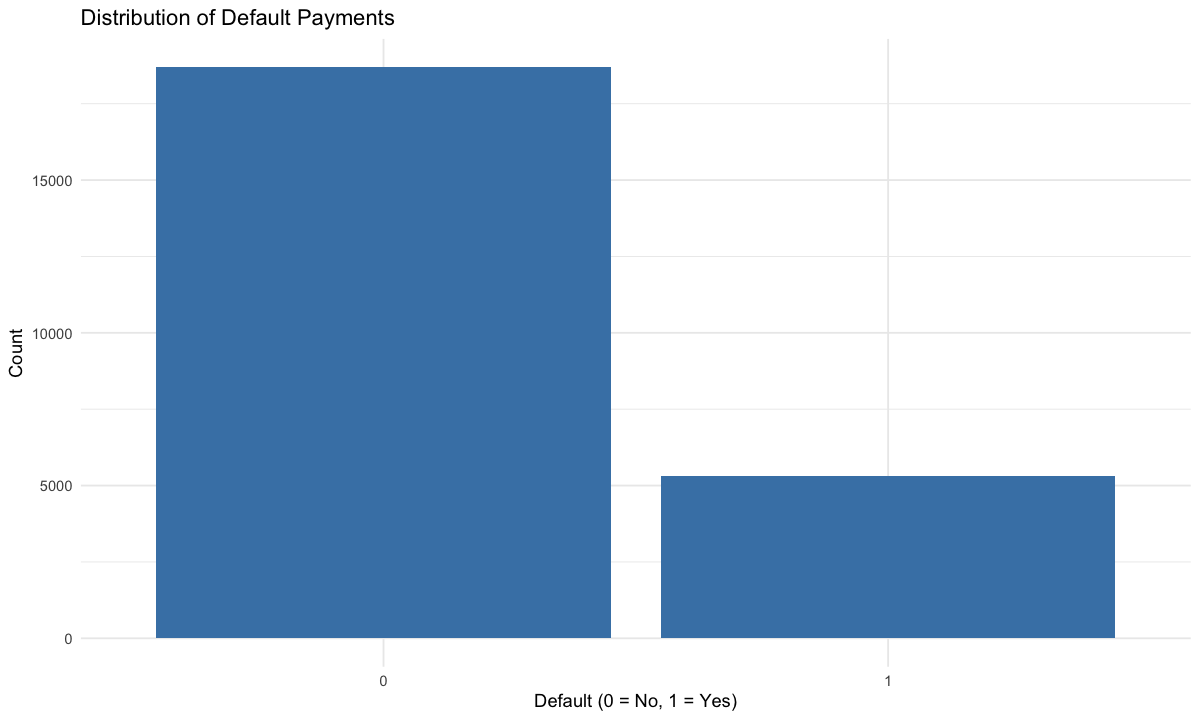

In [7]:
# Convert the target variable to a factor for better visualization
options(repr.plot.width = 10, repr.plot.height = 6)
train_df$default.payment.next.month <- as.factor(train_df$default.payment.next.month)

# Distribution of default payments
target_dis <- ggplot(train_df, aes(x = as.factor(default.payment.next.month))) +
  geom_bar(fill = "steelblue") +
  labs(title = "Distribution of Default Payments", x = "Default (0 = No, 1 = Yes)", y = "Count") +
  theme_minimal()


target_dis

Figure 1 - Distribution of default payments

`geom_smooth()` using formula = 'y ~ x'


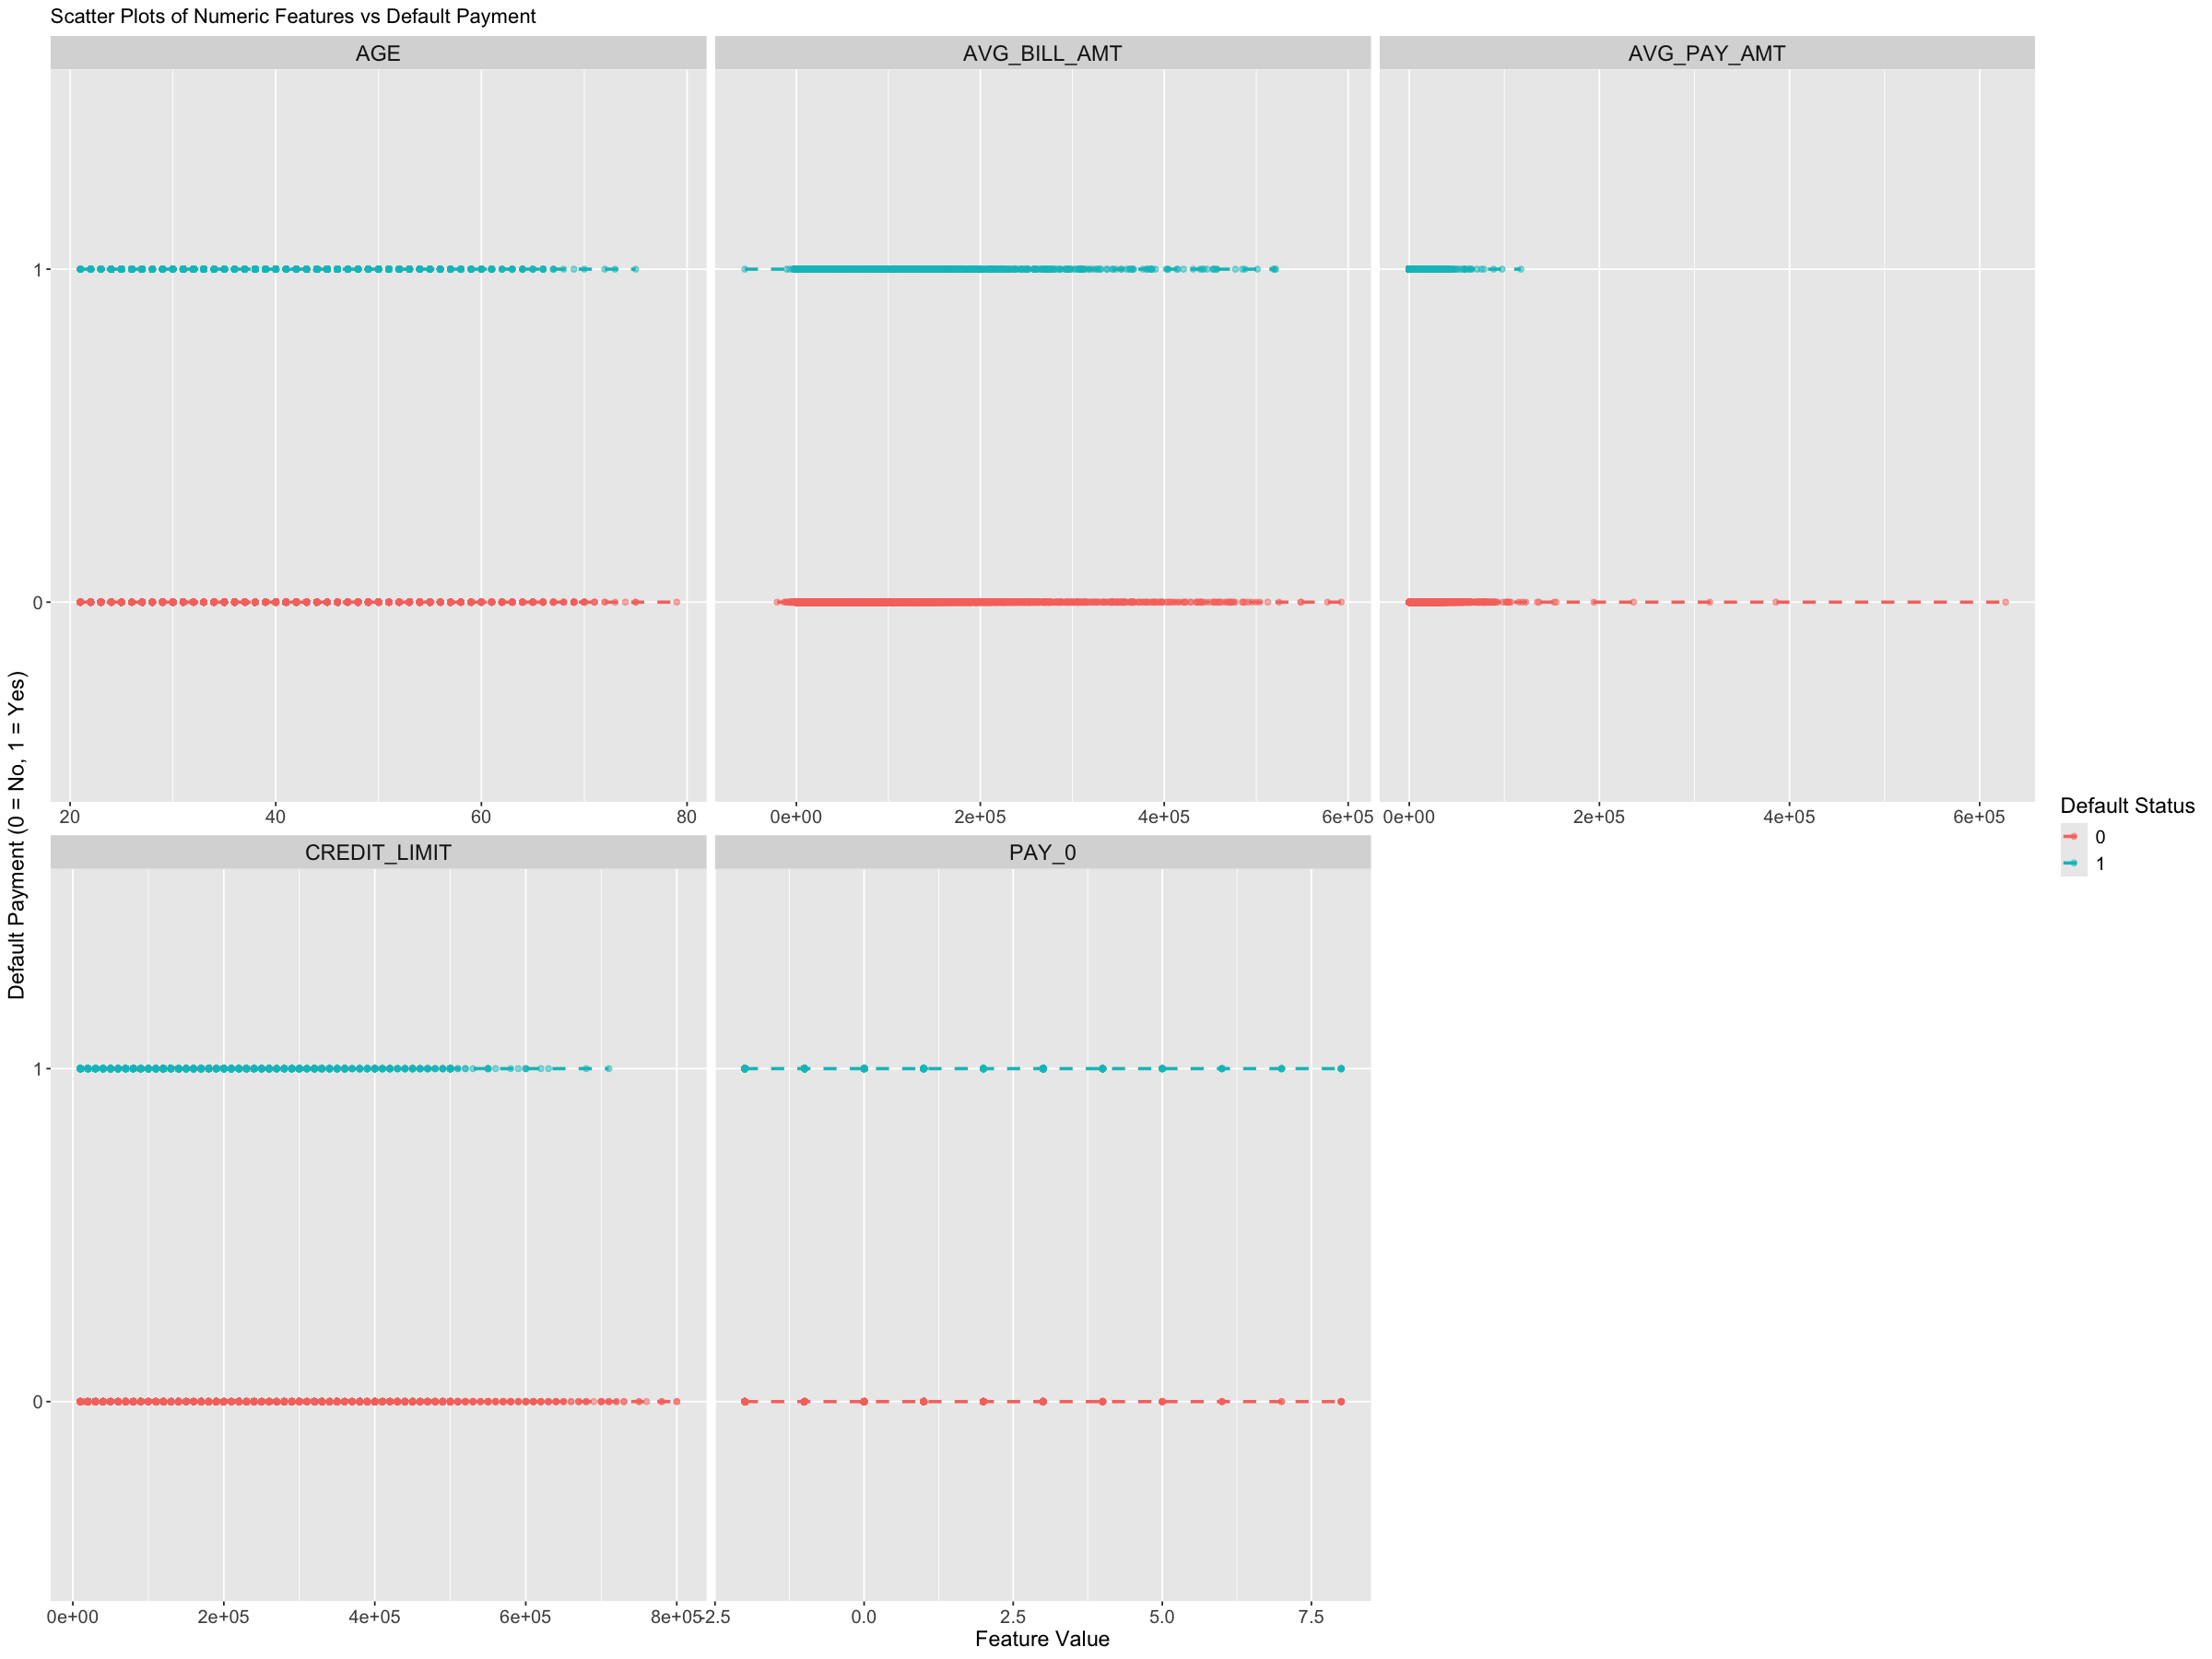

In [8]:
options(repr.plot.width = 20, repr.plot.height = 15)

# Reshape the dataset for facet grid visualization
df_long <- train_df %>% 
  pivot_longer(cols = c(CREDIT_LIMIT, AGE, AVG_BILL_AMT, AVG_PAY_AMT, PAY_0),
               names_to = "Feature", values_to = "Value")

# Scatter plots using facet grid with color for default class and trend lines, showing all the general distribution
# btw numeric variables and the target variable
ggplot(df_long, aes(x = Value, y = default.payment.next.month, color = default.payment.next.month)) +
  geom_point(alpha = 0.5) +
  geom_smooth(method = "lm", se = FALSE, linetype = "dashed") +
  facet_wrap(~ Feature, scales = "free_x") +
  labs(title = "Scatter Plots of Numeric Features vs Default Payment",
       x = "Feature Value", y = "Default Payment (0 = No, 1 = Yes)",
       color = "Default Status")  + theme(strip.text = element_text(size = 14),   
        axis.text = element_text(size = 12),    
        axis.title = element_text(size = 14),   
        legend.text = element_text(size = 12),  
        legend.title = element_text(size = 14)) 
    

Figure 2 - Scatter plots using facet grid with color for default class and trend lines, showing all the general distribution
between numeric variables and the target variable

### Model Training

	

Best k value: 18 
         Actual
Predicted    0    1
        0 4382  911
        1  291  416


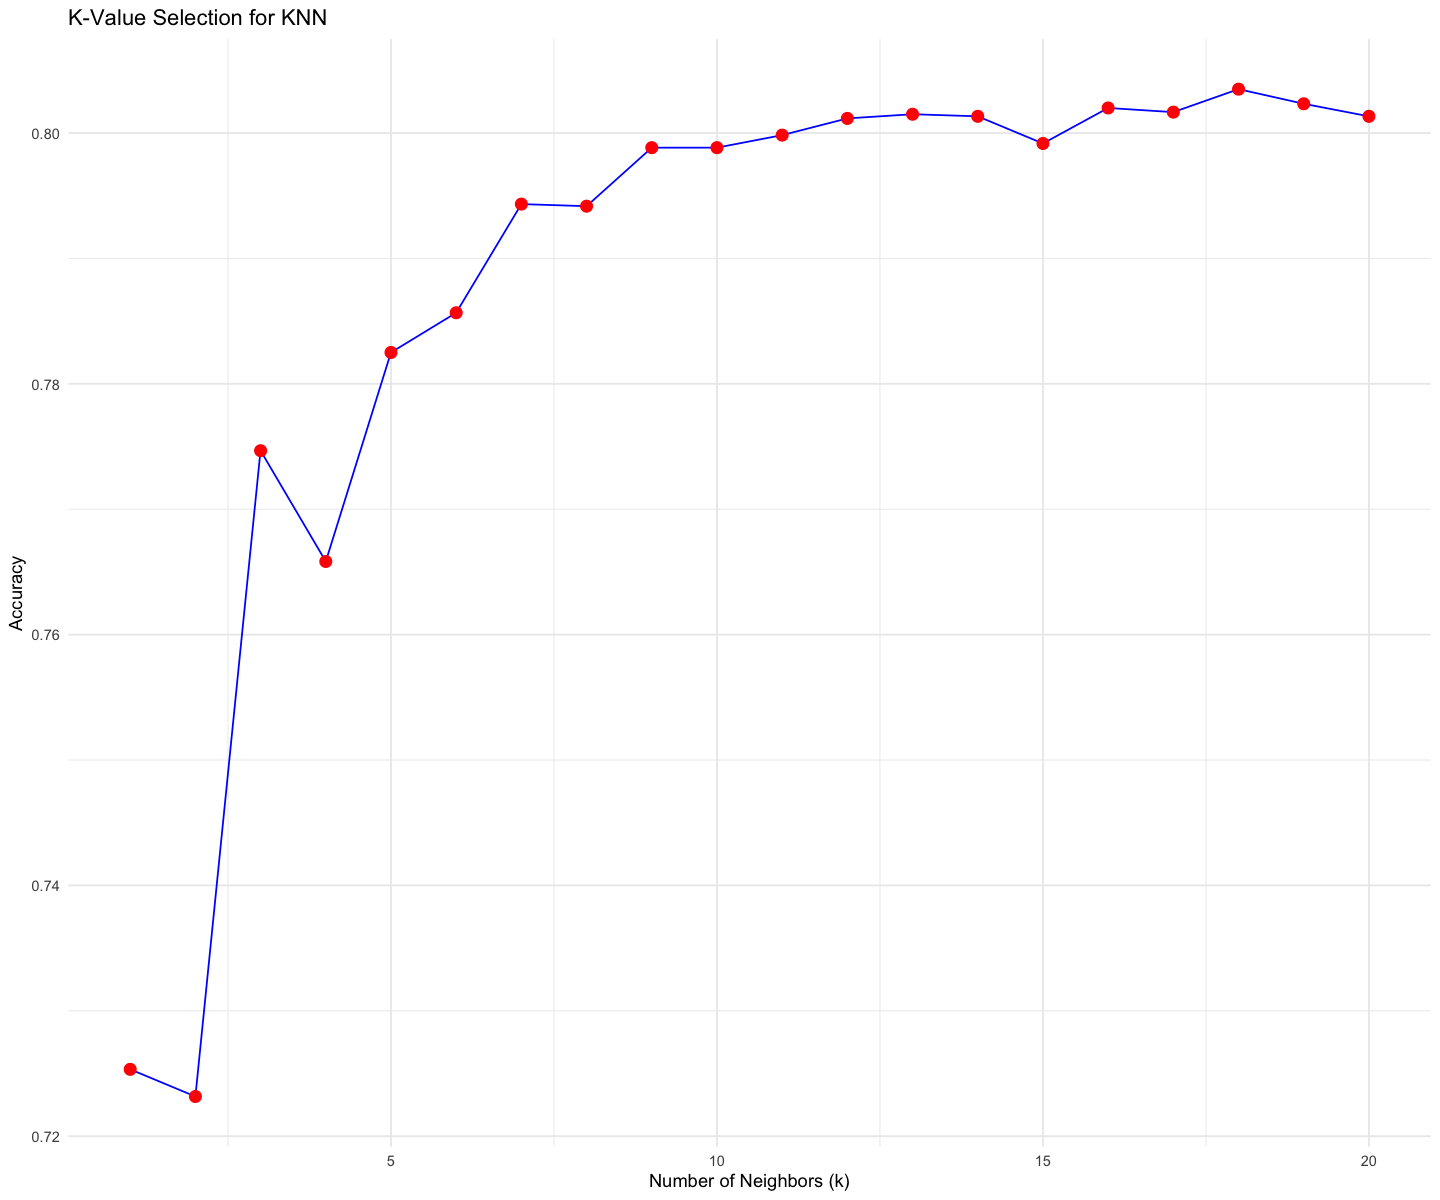

In [9]:
options(repr.plot.width = 12, repr.plot.height = 10)
# Define normalization function
normalize <- function(x) { (x - min(x)) / (max(x) - min(x)) }

# Select only numeric columns for normalization (excluding the target variable)
numeric_columns <- sapply(train_df, is.numeric)

# Extract target variable BEFORE normalization
train_labels <- as.factor(train_df$default.payment.next.month) 
test_labels <- as.factor(test_df$default.payment.next.month)    

# Apply normalization only to numeric columns (excluding the target variable)
train_df_norm <- as.data.frame(lapply(train_df[, numeric_columns], normalize))
test_df_norm <- as.data.frame(lapply(test_df[, numeric_columns], normalize))

# Remove the target variable from the normalized data (it should NOT be included in knn predictors)
train_df_norm <- train_df_norm[, colnames(train_df_norm) != "default.payment.next.month"]
test_df_norm <- test_df_norm[, colnames(test_df_norm) != "default.payment.next.month"]

# Try different k values and store accuracy results
k_values <- seq(1, 20, by = 1)  # Testing k from 1 to 20
accuracy_results <- data.frame(k = k_values, accuracy = NA)

for (i in 1:length(k_values)) {
  knn_pred <- knn(train = train_df_norm, test = test_df_norm, cl = train_labels, k = k_values[i])
  
 # Calculate accuracy
  accuracy_results$accuracy[i] <- sum(knn_pred == test_labels) / length(test_labels)
}

# Find the best k (highest accuracy)
best_k <- accuracy_results$k[which.max(accuracy_results$accuracy)]
cat("Best k value:", best_k, "\n")

# Plot accuracy vs. k to visualize the best k choice
ggplot(accuracy_results, aes(x = k, y = accuracy)) +
  geom_line(color = "blue") +
  geom_point(size = 3, color = "red") +
  labs(title = "K-Value Selection for KNN",
       x = "Number of Neighbors (k)",
       y = "Accuracy") +
  theme_minimal()

# Train KNN Model 
knn_model <- knn(train = train_df_norm, test = test_df_norm, cl = train_labels, k = best_k)

# Evaluate Model Performance
conf_matrix <- table(Predicted = knn_model, Actual = test_labels)
print(conf_matrix)

Figure 3 - K-Value Selection for KNN

### Performance Evaluation
- Accuracy & confusion matrix.
	

In [10]:
# Compute Accuracy, Precision, confusion matrix
confusion <- confusionMatrix(as.factor(knn_model), as.factor(test_labels))
print(confusion)

Confusion Matrix and Statistics

          Reference
Prediction    0    1
         0 4382  911
         1  291  416
                                          
               Accuracy : 0.7997          
                 95% CI : (0.7893, 0.8097)
    No Information Rate : 0.7788          
    P-Value [Acc > NIR] : 4.517e-05       
                                          
                  Kappa : 0.3017          
                                          
 Mcnemar's Test P-Value : < 2.2e-16       
                                          
            Sensitivity : 0.9377          
            Specificity : 0.3135          
         Pos Pred Value : 0.8279          
         Neg Pred Value : 0.5884          
             Prevalence : 0.7788          
         Detection Rate : 0.7303          
   Detection Prevalence : 0.8822          
      Balanced Accuracy : 0.6256          
                                          
       'Positive' Class : 0               
                        

## IV. Discussion

#### Summary of Result:
The best k-value for the K-Nearest Neighbors (KNN) model was determined to be 18. The plot above shows that as k increases, the accuracy stabilizes around 80%, suggesting an optimal balance between underfitting and overfitting.

Our K-Nearest Neighbors (KNN) classification model achieved an accuracy of 79.97%, indicating that it correctly predicts default and non-default cases in about 80% of instances. However, the model performs significantly better at identifying non-defaulters (sensitivity: 93.77%) than defaulters (specificity: 31.35%). The confusion matrix reveals a high false negative rate (911 cases), meaning that many actual defaulters were misclassified as non-defaulters. The balanced accuracy of 62.56% suggests that the model struggles with class imbalance, favoring the majority class (non-defaulters). To improve the result, we could use techniques to balance the dataset and try other classification models.

#### Expectations:
These results are partially expected. Since credit card defaults are typically imbalanced datasets, it was anticipated that the model might struggle with detecting defaulters. However, the low specificity was lower than expected, meaning the model fails to accurately identify defaulters more frequently than anticipated.
- We expected some bias toward the majority class (non-defaulters), but the high false negative rate suggests that KNN may not be the most effective method for this classification problem.

#### Impact of Findings:
Ideally, the model can serve as a valuable tool for financial institutions in assessing credit risk and making informed lending decisions. Effectively distinguish between defaulters and non-defaulters, reducing financial losses by minimizing the risk of approving loans for high-risk individuals. However, in our model, the high false negative rate poses a risk to financial institutions, as they might approve loans for individuals who are likely to default. The low specificity could result in misleading credit scores, potentially granting loans to individuals who are unable to repay while unfairly rejecting creditworthy applicants. These findings highlight the need for improving predictive models. 

#### Future Questions:

- How do external economic factors impact default rates?
    - Our model focuses on individual demographic and financial characteristics, but macroeconomic conditions such as inflation, interest rates, and unemployment rates could also play a crucial role in credit card default. Some existing studies have shown that “credit card default is not related to the amount of credit card customer’s income, but significantly to the stability of income” (Li et al., 2019). Future studies could incorporate these external factors to improve predictive accuracy.


- Can other algorithms improve prediction accuracy?
    - While KNN provides useful insights, exploring other classification models such as logistic regression, decision trees, etc. may yield better performance. A comparative analysis could determine the most effective model for predicting defaults.


- How does financial behavior change over time, and can we predict long-term default risk?
    - Our model predicts default based on a fixed time period, but analyzing customer behavior over longer durations could reveal trends in financial stability. 


## V. References

ICI.Radio-Canada.ca, Z. É.-. (n.d.). What you need to know about the new credit card surcharge: RCI. Radio. https://ici.radio-canada.ca/rci/en/news/1923776/what-you-need-to-know-about-the-new-credit-card-surcharge 

Learning, U. M. (2016, November 3). Default of credit card clients dataset. Kaggle. https://www.kaggle.com/datasets/uciml/default-of-credit-card-clients-dataset/data 

Li, Y., Li, Y., & Li, Y. (2019). What factors are influencing credit card customer’s default behavior in China? A study based on survival analysis. Physica A: Statistical Mechanics and Its Applications, 526, 120861. https://doi.org/10.1016/j.physa.2019.04.097 

Radage, K. (2023, July 31). The growth of the credit card industry in 2023. Credit Card Processing and Merchant Account. https://www.clearlypayments.com/blog/growth-of-credit-card-industry-in-2023/ 

Streaks, J. (n.d.). What is a credit card default? A complete guide. Business Insider. https://www.businessinsider.com/personal-finance/credit-score/what-is-a-credit-card-default 
